In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from time import time
import mpmath as mp
from numba import njit

In [2]:
class VanillaOption():

    def __init__(self, r, S, k, t):
        self.r = r
        self.S = S
        self.k = k
        self.t = t
        
        
class VanillaCall(VanillaOption):
    @property
    def price(self):
        return np.mean(np.maximum(self.S[:,-1] - self.k, 0)*np.exp(-self.r*self.t))
    
    
class VanillaPut(VanillaOption):
    @property
    def price(self):
        return np.mean(np.maximum(strike - equity[:,-1], 0)*np.exp(-discount))

In [3]:
class BSEuroOption():

    def __init__(self, r, q, S, sigma, k, t):
        self.r = r
        self.q = q
        self.S = S
        self.sigma = sigma
        self.k = k
        self.t = t
        self.d1 = ((np.log(self.S / self.k) + (self.r- self.q + np.square(self.sigma) / 2) * self.t)) / (sigma * np.sqrt(self.t))
        self.d2 = self.d1 - self.sigma * np.sqrt(self.t)


class BSCall(BSEuroOption):

    @property
    def price(self):
        # S * N(d1) - K * N(d2)
        return self.S * np.exp(-self.q * self.t) * norm.cdf(self.d1) - self.k * np.exp(-self.r * self.t) * norm.cdf(self.d2)

    @property 
    def delta(self):
        return np.exp(- self.q * self.t) * norm.cdf(self.d1) 

    @property 
    def gamma(self):
        return np.exp(- self.q * self.t) * norm.pdf(self.d1) / (self.sigma * self.S * np.sqrt(self.t)) 

    @property 
    def vega(self):
        return np.exp(- self.q * self.t) * norm.pdf(self.d1) * self.S * np.sqrt(self.t)
    
    
class BSPut(BSEuroOption):


    @property
    def price(self):
        return self.k * np.exp(-self.r * self.t) * norm.cdf(-self.d2) - self.S * np.exp(-self.q * self.t) * norm.cdf(-self.d1) 

    @property 
    def delta(self):
        return -1 * np.exp(- self.q * self.t) * norm.cdf(-self.d1)

    @property 
    def gamma(self):
        return np.exp(- self.q * self.t) * norm.pdf(self.d1) / (self.sigma * self.S * np.sqrt(self.t)) 

    @property 
    def vega(self):
        return np.exp(- self.q * self.t) * self.S * np.sqrt(self.t) *  norm.pdf(self.d1) / 100
        #return np.exp(- self.q * self.t) * np.sqrt(self.t) *  norm.pdf(self.d1) / 100

In [4]:
def simulate_GBM(sims, T, dt, S0, r, q, sigma):
    m = int(1/(T * dt))
    equity = np.zeros((sims, m+1))
    X = np.random.randn(sims, m)
    equity[:, 1:] = (r-q-sigma*sigma / 2) * dt + sigma * np.sqrt(dt) * X
    return S0 * np.exp(equity.cumsum(axis=1))
    

In [5]:
def simulate_VG(sims, T, dt, S0, r, q, sigma, nu, theta):
    m = int(1/(T * dt))
    omega = np.log(1 - theta*nu - sigma*sigma*nu/2)/nu
    equity = np.zeros((sims, m+1))
    drift = r - q + omega
    g = np.random.gamma(dt/nu, nu,(sims,m))
    X = theta*g + sigma*np.sqrt(g)*np.random.randn(sims, m)
    equity[:, 1:] = drift * dt + X
    return S0 * np.exp(equity.cumsum(axis=1))    

In [6]:
def simulate_VGSA(sims, T, dt, S0, r, q, sigma, nu, theta, kappa, eta, lam):
    m = int(1/(T * dt))
    omega = np.zeros((sims, m+1))
    iu = (1/nu) * np.log(1 - theta*nu - sigma*sigma*nu/2)
    gamma = np.sqrt(kappa*kappa - 2*lam*lam*iu)
    equity = np.zeros((sims, m+1))
    drift = r - q
    g = np.random.gamma(dt/nu, nu,(sims,m))
    X = VGSA_TimeChange(sims, T, dt, S0, r, q, sigma, nu, theta, kappa, eta, lam)
    jh = np.array([(ii)*dt for ii in range(m+1)], dtype=float)
    omega = np.log(phi(jh, kappa, eta, lam, gamma, iu, nu))
    domega = - np.diff(omega, prepend=0.0)                 
    equity[:, 1:] = drift * dt + domega[:-1].T + X[:,:-1]
    return S0 * np.exp(equity.cumsum(axis=1))  

def A(t, kappa, eta, lam, gamma, iu):
    num = np.exp(kappa*kappa*eta*t/(lam*lam))
    par = np.cosh(gamma*t/2) + (kappa/gamma)*np.sinh(gamma*t/2)
    ex = 2*kappa*eta/(lam*lam)
    return num/(par**ex)

def B(t, kappa, eta, lam, gamma, iu):
    return (2*iu) / (kappa +gamma*np.cosh(gamma*t/2)/np.sinh(gamma*t/2))

def phi(t, kappa, eta, lam, gamma, iu, nu):
    
    return A(t, kappa, eta, lam, gamma, iu)*np.exp(B(t, kappa, eta, lam, gamma, iu)/nu)

def VGSA_TimeChange(sims, T, dt, S0, r, q, sigma, nu, theta, kappa, eta, lam):
    m = int(1/(T * dt))
    y = np.zeros((sims, m+1))
    X = np.zeros((sims, m+1))
    y[:,0] = 1/nu
    Z1 = np.random.randn(sims, m)
    Z2 = np.random.randn(sims, m)
    for n in range(m):

        y[:,n+1] = (y[:,n] + kappa*(eta - y[:,n])*dt + lam*np.sqrt(y[:,n])*np.sqrt(dt)*Z1[:,n]
                   + (lam*lam)/4 * dt * (Z1[:,n]**2 - 1))
        t_tilda = dt/2 * (y[:,n+1] +y[:,n])
        g = np.random.gamma(t_tilda/nu, nu,sims)
        X[:,n] = theta*g + sigma*np.sqrt(g)*Z2[:,n]     
    return X

In [7]:
import pyodbc

In [8]:
EffectiveDate = "'2021-12-31'"
connstr = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=actuarialdata.nwie.net,1021;DATABASE=NFActCorp;Trusted_Connection=yes;'
query = "EXEC [EconData].[Curve_NominalRates_Get] " + EffectiveDate
query2 = "Exec NFActCorp.QRM.SHARED_VOL_SURFACE_PIVOT_GET 'Master'," + EffectiveDate + ", 'SPX'"
query3 = "Exec NFActCorp.QRM.BBG_Closes_Scalar_Get 'SPX INDEX', 'EQY_DVD_YLD_12M', " + EffectiveDate
query4 = "select [Input_EquityVolatility] "
query4 += "FROM EconData.vw_VCFStateParameters "
query4 +="WHERE [FundName] = 'NVIT ID Managed Growth' "
query4 += "and	[AlgorithmVersion] = 1.0 "
query4 += "and EffectiveDate = "
query4 += EffectiveDate
query4 += " order by EffectiveDate"
rates = []
ivol = []
div = []
vol = []
with pyodbc.connect(connstr) as cnxn:

    with cnxn.cursor() as crs:
        crs.execute(query)
        for row in crs:
            rates.append(row)
    with cnxn.cursor() as crs:
        crs.execute(query2)
        for row in crs:
            ivol.append(row)
    with cnxn.cursor() as crs:
        crs.execute(query3)
        for row in crs:
            div.append(row)
    with cnxn.cursor() as crs:
        crs.execute(query4)
        for row in crs:
            vol.append(row)        
iVols_1yr = np.array(ivol[:][:][11][3:])
rate_1yr = rates[0][4] / 100
q = div[0][0] / 100
v0 = vol[0][0]

In [9]:
@njit
def HESTON_VOL(rvs, nsim=100000, timesteps=360, maturity=1, psi=.3877, theta = 0.18*0.18, kappa = 2, V0 = .18):
    dt = maturity / timesteps
    V = np.zeros((nsim, timesteps+1))
    V[:,0] = V0*V0
    for n in range(timesteps):
        rv = rvs[:,n]
        V[:,n+1] = (np.maximum(V[:,n] + kappa * (theta - V[:,n]) * dt + 
                               psi * np.sqrt(np.maximum(V[:,n],0.0001)) * rv * np.sqrt(dt), 0.0001))
    Vol = np.sqrt(V)
    return Vol


def simulate_GBMSA(sims, T, dt, S0, V0, r, q, psi, kappa, rho, theta):
    m = int(1/(T * dt))
    equity = np.zeros((sims, m+1))
    X1 = np.random.randn(sims, m)
    X2 = np.random.randn(sims, m)
    X3 = rho * X1 + np.sqrt(1-rho*rho)*X2
    vol = HESTON_VOL_njit(X1, sims, m, T, psi, theta, kappa, V0)
    equity[:, 1:] = (r-q-vol[:,0:-1]*vol[:,0:-1] / 2) * dt + vol[:,0:-1] * np.sqrt(dt) * X3
    return S0 * np.exp(equity.cumsum(axis=1))

In [10]:
def EuroPricer(strike, discount, optiontype, equity):
    if optiontype == 'C':
        Price = np.mean(np.maximum(equity[:,-1] - strike, 0)*np.exp(-discount))
    else:
        Price = np.mean(np.maximum(strike - equity[:,-1], 0)*np.exp(-discount))
    return Price

In [18]:
from abc import ABC, abstractmethod
from typing import Tuple, List, Sequence, Dict, Union
from scipy.optimize import minimize, OptimizeResult 
from scipy.optimize import Bounds
from random import seed
from scipy.optimize import least_squares

class OptionPricingModel(ABC):
    """
    Model that can be used to price Euoprean Vanilla Options.
    """
    
    def __init__(self):
        self._parameters = None
    
    @property
    def parameters(self) -> Sequence[float]:
        """
        The model parameters, returned as a list of real numbers.
        """
        return self._parameters

    
    @parameters.setter
    @abstractmethod
    def parameters(self, value: Sequence[float]):
        """
        The model parameters, returned as a list of real numbers.
        """
        pass
        
    
    @abstractmethod
    def simulate(self):
        pass   
        
        
    def calibrate(self, real_prices, strikes, maturities, weight: np.array=None):
        if weight is None:
            weight = np.ones(real_prices.shape)
        dt = 1/360
        sims = 10000
        simlen = max(maturities)
        cols = (maturities / dt + 1).astype(int)
        loss = self.get_loss_function(real_prices, weight, strikes, maturities, sims, simlen, cols, dt)
        res = minimize(loss, self.parameters, options=self.options, bounds=self.bounds, method=’Nelder-Mead’)
        self.parameters = res.x
        return res, self
        
    def get_loss_function(self, real_prices, weight, strikes, maturities, sims, simlen, cols, dt):    

        def _loss_function(parameters):
            np.random.seed(1234)
            self.parameters = parameters
            S = self.simulate(sims, simlen, dt)
            predicted = []
            for i in range(len(strikes)):
                pricingOption = VanillaCall(self.r, S[:,:cols[i]], self.s0*strikes[i], maturities[i])
                predicted.append(pricingOption.price)
            return sum(weight*(real_prices - np.array(predicted, dtype=float))**2)
        return _loss_function    

SyntaxError: invalid character in identifier (<ipython-input-18-3df98ebb2000>, line 46)

In [67]:
class GBMSA(OptionPricingModel):
    
    def __init__(self, s0, v0, r, q, psi, kappa, rho, theta):
        super().__init__()
        self.r = r
        self.q = q
        self.s0 = s0
        self.v0 = v0
        self.psi = psi
        self.kappa = kappa
        self.rho = rho
        self.theta = theta
        self.bounds = ((0.10, 1.0), (0.5, 10.0), (-0.99, 0.99), (0.05, 1.0))
        self.options = {'gtol': 1e-6, 'disp': True}
        self.parameters = (self.psi, self.kappa, self.rho, self.theta)
    
    @property
    def parameters(self) -> Sequence[float]:
        """
        The model parameters, returned as a list of real numbers.
        """
        return self._parameters
    
    @parameters.setter
    def parameters(self, value):
        if value is not None:
            self.psi = value[0]
            self.kappa = value[1]
            self.rho = value[2]
            self.theta = value[3]
            self._parameters = value

            
    def HESTON_VOL(self,rvs, nsim=100000, timesteps=360, maturity=1, psi=.3877, theta = 0.18*0.18, kappa = 2, v0 = .18):
        dt = maturity / timesteps
        v = np.zeros((nsim, timesteps+1))
        v[:,0] = v0*v0
        for n in range(timesteps):
            rv = rvs[:,n]
            v[:,n+1] = np.maximum(v[:,n] + kappa * (theta - v[:,n]) * dt + 
                                   psi * np.sqrt(v[:,n]) * rv * np.sqrt(dt),0.01)
                
        vol = np.sqrt(v)
        return vol

    def simulate(self, sims, T, dt):
        m = int(T/(1 * dt))
        equity = np.zeros((sims, m+1))
        X1 = np.random.randn(sims, m)
        X2 = np.random.randn(sims, m)
        X3 = self.rho * X1 + np.sqrt(1-self.rho*self.rho)*X2
        vol = self.HESTON_VOL(X1, sims, m, T, self.psi, self.theta, self.kappa, self.v0)
        equity[:, 1:] = (self.r-self.q-vol[:,0:-1]*vol[:,0:-1] / 2) * dt + vol[:,0:-1] * np.sqrt(dt) * X3
        return self.s0 * np.exp(equity.cumsum(axis=1))

In [13]:
class VG(OptionPricingModel):
    
    def __init__(self, s0, r, q, sigma, nu, theta):
        super().__init__()
        self.r = r
        self.q = q
        self.s0 = s0
        self.sigma = sigma        
        self.nu = nu
        self.theta = theta
        self.bounds = ((0.001, 10.0), (0.001, 10.0), (-10.0, 10.0))
        self.options = {'disp': True}
        self.parameters = (self.sigma, self.nu, self.theta)
    
    @property
    def parameters(self) -> Sequence[float]:
        """
        The model parameters, returned as a list of real numbers.
        """
        return self._parameters
    
    @parameters.setter
    def parameters(self, value):
        if value is not None:
            self.sigma = value[0]
            self.nu = value[1]
            self.theta = value[2]
            self._parameters = value


    def simulate(self, sims, T, dt):
        m = int(1/(T * dt))
        omega = np.log(1 - self.theta*self.nu - self.sigma*self.sigma*self.nu/2)/self.nu
        equity = np.zeros((sims, m+1))
        drift = self.r - self.q + omega
        g = np.random.gamma(dt/self.nu, self.nu,(sims,m))
        X = self.theta*g + self.sigma*np.sqrt(g)*np.random.randn(sims, m)
        equity[:, 1:] = drift * dt + X
        return self.s0 * np.exp(equity.cumsum(axis=1))   

In [14]:
st = time()
r = rate_1yr
q = q
s0 = 100
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.90, 1.00, 1.10, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
iVols = iVols_1yr
options = []
for i in range(len(iVols)):
    options.append(BSCall(r, q, s0, iVols[i], s0*strikes[i], maturities[i]))
real_prices = np.array([o.price for o in options])
np.set_printoptions(precision=2, suppress=True)
print(real_prices)
print(f'Elapsted time is {time() - st:.2f} seconds.')

[49.52 40.07 30.88 22.21 14.22  7.3   2.47  0.62  0.21  0.08  0.03]
Elapsted time is 0.00 seconds.


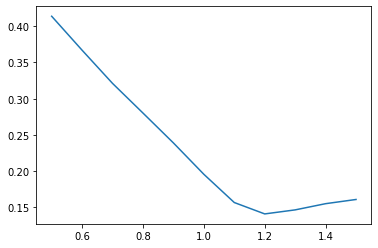

In [27]:
plt.plot(strikes, iVols)

In [20]:
np.random.seed(12345)
st = time()
psi = .3
kappa = 1.0
rho = 0
theta = v0**2
k = 100
T = 1
dt = 1/360
sims = 100000
model = GBMSA(s0, v0, r, q, psi, kappa, rho, theta)
S = model.simulate(sims, 1, 1/360)
h_options = []
for s in range(len(strikes)):
    h_options.append(VanillaCall(r, S, strikes[s]*100,1))
h_prices = np.array([o.price for o in h_options])
print(h_prices)
print(f'Elapsted time is {time() - st:.2f} seconds.')
sum((h_prices - real_prices)**2)

[48.91 38.98 29.19 19.95 12.1   6.47  3.13  1.44  0.65  0.3   0.15]
Elapsted time is 5.66 seconds.


16.078902446766094

In [71]:
#  def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
print(f'${analyticalheston_price( 127.62, 130, .2*.2, 0.1, .2*.2, 0.1, -0.75, 0, 252/365, 0.001-0.0163 ):.2f}')

$6.53


In [69]:
np.random.seed(12345)
v0 = 0.2
sims = 100000
T = 252/365
dt = 1/(360*4)
model = GBMSA(127.62, v0, 0.001, 0.0163, 0.1, 0.1, -0.75, v0*v0)
S = model.simulate(sims, T, dt)
print(f'${VanillaCall(0.001, S, 130, 252/365).price:.2f}')

$6.53


In [66]:
T = 252/365
dt = 1/360
int(T/(1 * dt))

248

In [28]:
from scipy.integrate import quad

In [70]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    
    # constants
    a = kappa*theta
    b = kappa+lambd
    
    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )
    
    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)
    
    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2


def integrand(phi, S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator


def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width

    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)
        
        P += dphi * numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)


def analyticalheston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    real_integral, err = np.real( quad(integrand, 0, 10000, args=args) )
    
    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

In [25]:
st = time()
model.calibrate(real_prices, strikes, maturities)
print(f'Elapsted time is {time() - st:.2f} seconds.')

Elapsted time is 18.01 seconds.


In [40]:
type(1j)

complex

In [26]:
print(f'Heston Psi :  {model.parameters[0]:.2%}.')
print(f'Heston Kappa :  {model.parameters[1]:.2f}.')
print(f'Heston Rho :  {model.parameters[2]:.2%}.')
print(f'Heston Theta(vol) :  {np.sqrt(model.parameters[3]):.2%}.')

Heston Psi :  55.62%.
Heston Kappa :  0.50.
Heston Rho :  -99.00%.
Heston Theta(vol) :  22.36%.


In [19]:
np.random.seed(12345)
st = time()
S = model.simulate(sims, 1, 1/360)
h_options = []
for s in range(len(strikes)):
    h_options.append(VanillaCall(r, S, strikes[s]*100,1))
h_prices = np.array([o.price for o in h_options])
print(h_prices)
print(f'Elapsted time is {time() - st:.2f} seconds.')
sum((h_prices - real_prices)**2)

[4.91953460e+01 3.95806389e+01 3.02953371e+01 2.15516629e+01
 1.36804927e+01 7.21974764e+00 2.87220931e+00 7.92716242e-01
 1.46535644e-01 1.96166797e-02 2.14455387e-03]
Elapsted time is 5.54 seconds.


1.6090873236258225

In [20]:
np.random.seed(12345)
st = time()
k = 100
T = 1
dt = 1/360
sims = 100000
model2 = VG(s0, r, q, 0.1, 0.1, 0.1)
S2 = model2.simulate(sims, 1, 1/360)
vg_options = []
for s in range(len(strikes)):
    vg_options.append(VanillaCall(r, S2, strikes[s]*100,1))
vg_prices = np.array([o.price for o in vg_options])
print(vg_prices)
print(f'Elapsted time is {time() - st:.2f} seconds.')
sum((vg_prices - real_prices)**2)

[4.88922146e+01 3.89311386e+01 2.89706475e+01 1.90559524e+01
 9.91307293e+00 3.71651273e+00 1.06345187e+00 2.59997119e-01
 6.09767592e-02 1.40895087e-02 3.56325164e-03]
Elapsted time is 4.27 seconds.


48.822780260479504

In [21]:
st = time()
model2.calibrate(real_prices, strikes, maturities)
print(f'Elapsted time is {time() - st:.2f} seconds.')

Elapsted time is 100.57 seconds.


In [22]:
print(f'VG Sigma :  {model2.parameters[0]:.2f}.')
print(f'VG Nu :  {model2.parameters[1]:.2f}.')
print(f'VG Theta :  {model2.parameters[2]:.2f}.')

VG Sigma :  0.18.
VG Nu :  0.00.
VG Theta :  -2.31.


In [23]:
st = time()
np.random.seed(12345)
S2 = model2.simulate(sims, 1, 1/360)
vg_options = []
for s in range(len(strikes)):
    vg_options.append(VanillaCall(r, S2, strikes[s]*100,1))
vg_prices = np.array([o.price for o in vg_options])
print(vg_prices)
print(f'Elapsted time is {time() - st:.2f} seconds.')
sum((vg_prices - real_prices)**2)

[48.91007389 38.97885651 29.25260162 20.27374349 12.79682808  7.33144579
  3.83152194  1.84538636  0.82338175  0.34450599  0.1366161 ]
Elapsted time is 4.38 seconds.


13.776110311345404

In [24]:
print(f'For 90% strike, the actual price is ${real_prices[4]:.2f}')
print(f'The VGSA price is ${h_prices[4]:.2f}, and the VG price is ${vg_prices[4]:.2f}')
print('------------------------')
print(f'For ATM strike, the actual price is ${real_prices[5]:.2f}')
print(f'The VGSA price is ${h_prices[5]:.2f}, and the VG price is ${vg_prices[5]:.2f}')
print('------------------------')
print(f'For 110% strike, the actual price is ${real_prices[6]:.2f}')
print(f'The VGSA price is ${h_prices[6]:.2f}, and the VG price is ${vg_prices[6]:.2f}')

For 90% strike, the actual price is $14.22
The VGSA price is $13.68, and the VG price is $12.80
------------------------
For ATM strike, the actual price is $7.30
The VGSA price is $7.22, and the VG price is $7.33
------------------------
For 110% strike, the actual price is $2.47
The VGSA price is $2.87, and the VG price is $3.83


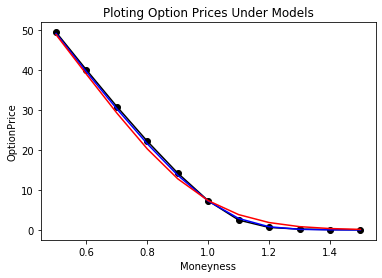

In [25]:
plt.plot(strikes,real_prices, color='black', marker='o')
plt.plot(strikes,h_prices, color='blue')
plt.plot(strikes,vg_prices, color='red')
plt.title('Ploting Option Prices Under Models')
plt.xlabel('Moneyness')
plt.ylabel('OptionPrice')
plt.show()

In [26]:
def RebateBufferPricer(buffer, discount, rebate, equity):
    k = (1-buffer)*equity[:,0]
    rebate = rebate * equity[:,0]
    Price = np.mean(((equity[:,-1] >= k)*rebate - np.maximum(k - equity[:,-1], 0))*np.exp(-discount))

    return Price

In [27]:
buffer = 0.10
discount = r * T
rebate = 0.09
equity = S
print(f'{RebateBufferPricer(buffer, discount, rebate, equity)/s0:.2%}')

1.98%


In [28]:
y = []
for i in np.arange(1,30):
    rebate = i * .0050
    y.append(RebateBufferPricer(buffer, discount, rebate, equity)/s0)

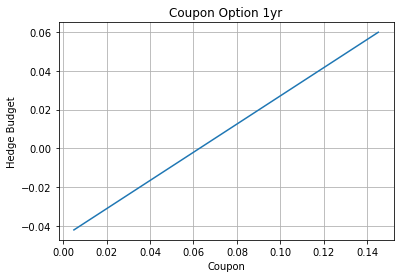

In [29]:
plt.plot(np.arange(1,30)*0.0050,y)
plt.xlabel("Coupon")
plt.ylabel("Hedge Budget")
plt.title("Coupon Option 1yr")
plt.grid(True)